In [242]:
import tensorflow as tf
import numpy as np
import pandas as pd , sys
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import clear_output
from sklearn.metrics import auc , roc_auc_score
from sklearn.model_selection import train_test_split
sys.path.append("/home/advice/Python/SR/Custom/")
from RAdam import RAdamOptimizer
import seaborn as sns
import re , os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplot
from ColumnMatch import MatchVariable

In [243]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

In [245]:
import os
os.path.abspath("./../../../Data/")

'/home/advice/Python/SR/Data'

In [246]:
data = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-train-0.2-0.0.csv")
in_var = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
          "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
          "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
target_var = ['default payment next month']
fac_var = [ 'SEX','EDUCATION','MARRIAGE',]
num_var = [i for i in in_var if not i in fac_var]
#in_var = num_var + fac_var
data[fac_var] = data[fac_var].astype("category")

In [247]:
cat_col = data.select_dtypes("category").columns.tolist()
onehot_data = pd.get_dummies(data , columns= cat_col)

In [248]:
select_var = in_var + target_var + ["sep_idx"]
data = data[select_var]

In [249]:
train = data[data.sep_idx ==1 ]
valid = data[data.sep_idx ==0 ]
## 
train = data
_ = train.pop("sep_idx")
_ = valid.pop("sep_idx")

In [250]:
Train_X = pd.get_dummies(train , columns= cat_col)
Train_y = Train_X.pop(target_var[0])

In [251]:
num_var = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [252]:
one_hot_var = Train_X.columns.tolist()
#in_var = data.columns.tolist()

In [253]:
MV = MatchVariable()
in_var = MV.match_invar(one_hot_var , in_var)

In [254]:
key_onehot_store , onehot_store = MV.OneHotIndex(in_var , num_var , one_hot_var)

In [255]:
#key_onehot_store , onehot_store = OneHotIndex(in_var , num_var , one_hot_var)

In [256]:
test = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-test-0.2-0.0.csv")
Test_y = test.pop(target_var[0])
Test_X = pd.get_dummies(test , columns= fac_var)[one_hot_var]

In [257]:
Train_y.reset_index(drop=True ,inplace=True)
target_1_list = Train_y[(Train_y == 1) == True].index.tolist()
target_0_list = Train_y[(Train_y == 0) == True].index.tolist()

In [258]:
ck = list(set(target_1_list) & set(target_0_list))
assert ck == [], "중복 발생 : {}".format(ck)

In [259]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder ,
    MinMaxScaler , RobustScaler,
    PowerTransformer
)

In [260]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from collections import Counter
from copy import deepcopy
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]
    
class OutlierTransformer(BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features = True , multiple_outlier_n = 5):
        self.multiple_outlier_n = multiple_outlier_n
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X:pd.DataFrame, y = None )-> dict:
        self.Detect_Outlier = {}
        df = deepcopy(X)
        outlier_indices = [] 
        # convert columns to numerical
        self.totalcol = df.columns.tolist()
        print(self.totalcol)
        for name in self.totalcol :
            selectvar = df[name]
            Q1, Q3 = selectvar.quantile([0.25,0.75]).values
            IQR = Q3 - Q1
            minimum , maximum = (Q1 - 1.5 * IQR) , (Q3 + 1.5 * IQR)
            select_idx = (selectvar  < minimum ) | (selectvar > maximum)
            outlier_list_col = selectvar[select_idx].index.tolist()
            outlier_indices.extend(outlier_list_col)
            self.Detect_Outlier[name] = [minimum , maximum]
        outlier_indices = Counter(outlier_indices) 
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > self.multiple_outlier_n)
        print(f"{self.multiple_outlier_n} Column Dudicated Outlier Index : {len(multiple_outliers)}")
        return self
    
    def transform(self, X:pd.DataFrame , y = None ) -> pd.DataFrame :
        df = deepcopy(X)
        for name in self.totalcol :
            selectvar = df[name]
            Q1, Q3 = selectvar.quantile([0.25,0.75]).values
            IQR = Q3 - Q1
            minimum , maximum = self.Detect_Outlier[name]
            select_idx = (selectvar  < minimum ) | (selectvar > maximum)
            selectvar[select_idx] = np.nan
            df[name] = selectvar
        print(df.shape)
        return df    
    def get_feature(self) :
        return self.totalcol

In [261]:
numeric_pipe = Pipeline([("Outlier", OutlierTransformer(multiple_outlier_n=5)),
                         ("imputer", SimpleImputer(strategy='mean')),
                         ("scaler2", MinMaxScaler(feature_range=(-2,2)))])
col_transformer = ColumnTransformer(transformers=[("nums",numeric_pipe , num_var)],n_jobs=None)

In [262]:
col_transformer.fit(Train_X)
Train_X[num_var] = col_transformer.transform(Train_X)
Test_X[num_var] = col_transformer.transform(Test_X)

['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
5 Column Dudicated Outlier Index : 1718
(30000, 20)
(30000, 20)
(6004, 20)


In [263]:
print(col_transformer.named_transformers_["nums"].steps[0][1].totalcol)

['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## 앙상블 테스트

In [264]:
Train_X_np = Train_X.values
#Valid_X_np = Valid_X.values
Test_X_np = Test_X.values

In [265]:
Train_X_np

array([[-1.92156863, -1.69230769,  0.2980045 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.1372549 , -1.48717949, -0.66666667, ...,  0.        ,
         1.        ,  0.        ],
       [-1.37254902, -0.54243209,  0.66666667, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.45098039, -0.66666667,  0.2980045 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.90196078,  0.25641026,  0.2980045 , ...,  0.        ,
         1.        ,  0.        ],
       [-1.45098039,  0.05128205,  2.        , ...,  0.        ,
         0.        ,  0.        ]])

In [266]:
row , dim = Train_X_np.shape
print(row,dim)
target_n = 2 
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [ None , dim])
y = tf.placeholder(tf.float32, shape = [ None , 1])
DropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
training = tf.placeholder_with_default(False, shape=[], name="training")

30000 33


In [267]:
TOTAL_DIM , h_dim , h_dim2 = dim , 20 , 10
Weight1 =get_weight_variable(shape = [TOTAL_DIM , h_dim], 
                            name=f"W1",type='he_normal', regularize=True)
Weight2 =get_weight_variable(shape = [h_dim , h_dim2], 
                            name=f"W2",type='he_normal', regularize=True)

In [268]:
encodelayer1 = tf.matmul(X ,Weight1)
code = tf.matmul(encodelayer1, Weight2)
decodelayer1 = tf.matmul(code, Weight2 , transpose_a=False , transpose_b=True )
trans_x = tf.matmul(decodelayer1, Weight1 , transpose_a=False , transpose_b=True )

In [269]:
loss = tf.reduce_mean(tf.square(X - trans_x))

In [270]:
vars = tf.trainable_variables()

In [273]:
print(vars)

[<tf.Variable 'W1:0' shape=(33, 20) dtype=float32_ref>, <tf.Variable 'W2:0' shape=(20, 10) dtype=float32_ref>]


In [271]:
solver = tf.train.AdamOptimizer(learning_rate= 1e-4).minimize(loss ,var_list = vars )

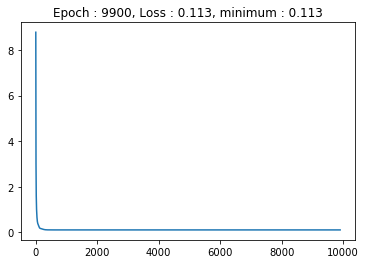

In [272]:
Epoch = 10000
mb_size = 1000
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)
_Loss_ = []
_Epoch_ = []
print("Train")
for epoch in range(Epoch) :
    print(epoch , end = "\r")
    idx = np.random.permutation(len(Train_X_np))
    XX = Train_X_np[idx , : ]
    batch_iter = int(len(XX) / mb_size)
    batchLoss = 0
    for idx in range(batch_iter) :
        X_mb = XX[idx*mb_size:(idx+1)*mb_size]
        Feed = {X : X_mb }
        _ , LOSS  = sess.run([solver , loss] , feed_dict= Feed)
        batchLoss += LOSS
    batchLoss /= batch_iter
    _Loss_.append(batchLoss)
    _Epoch_.append(epoch)
    if epoch % 100 == 0 :
        clear_output()
        plt.plot(_Epoch_ , _Loss_ )
        select= np.argmin(_Loss_)
        msg = f"Epoch : {epoch}, Loss : {batchLoss:.3f}, minimum : {_Loss_[select]:.3f}"
        plt.title(msg)
        plt.show()

1039